In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import (confusion_matrix, classification_report, 
                            roc_auc_score, roc_curve, precision_recall_curve,
                            average_precision_score)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

# Set random seeds and device
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
def load_data(file_path):
    # Load and shuffle full dataset
    full_data = pd.read_csv(file_path).sample(frac=1, random_state=42)
    X = full_data.drop('Outcome', axis=1).values.astype(np.float32)
    y = full_data['Outcome'].values.astype(np.int32)
    
    # Initial split: 80% train+val, 20% test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Split trainval into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42
    )
    
    # Scale data properly
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = load_data(
    'D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\chbmit_preprocessed_data.csv'
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (1342176, 23), Val: (335544, 23), Test: (419430, 23)


In [5]:
# Create TensorDatasets
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

# Create DataLoaders
batch_size = 4096
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True, pin_memory_device=str(device)
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size,
    num_workers=4, pin_memory=True, pin_memory_device=str(device)
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size,
    num_workers=4, pin_memory=True, pin_memory_device=str(device)
)

In [6]:
class EEGSeizureNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

In [22]:
class Trainer:
    def __init__(self, model, device, optimizer, criterion):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.best_roc = 0.0
        self.history = {'train_loss': [], 'val_loss': [], 
                       'train_acc': [], 'val_acc': [], 
                       'val_roc': []}

    def _run_epoch(self, loader, training=True):
        self.model.train(training)
        loss, correct, total = 0.0, 0, 0
        all_probs, all_labels = [], []
        
        with torch.set_grad_enabled(training):
            for inputs, labels in tqdm(loader, desc="Training" if training else "Validating"):
                inputs = inputs.to(self.device, non_blocking=True)
                labels = labels.to(self.device, non_blocking=True).unsqueeze(1)
                
                if training: self.optimizer.zero_grad()
                outputs = self.model(inputs)
                batch_loss = self.criterion(outputs, labels)
                
                if training:
                    batch_loss.backward()
                    self.optimizer.step()
                
                loss += batch_loss.item()
                preds = (outputs >= 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                all_probs.append(outputs.detach().cpu())
                all_labels.append(labels.detach().cpu())
        
        return (loss/len(loader)), (correct/total)*100, \
               torch.cat(all_probs), torch.cat(all_labels)

    def train(self, train_loader, val_loader, epochs=50):
        for epoch in range(epochs):
            train_loss, train_acc, _, _ = self._run_epoch(train_loader)
            val_loss, val_acc, val_probs, val_labels = self._run_epoch(val_loader, False)
            
            # Calculate validation ROC AUC
            val_roc = roc_auc_score(val_labels.numpy(), val_probs.numpy())
            
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['val_roc'].append(val_roc)
            
            # Save best model
            if val_roc > self.best_roc:
                self.best_roc = val_roc
                torch.save(self.model.state_dict(), 'best_model_CNN.pth')

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
            print(f"Val ROC AUC: {val_roc:.4f}")
            print("-----------------------------------")

            
   
    def evaluate(self, test_loader):
        self.model.load_state_dict(torch.load('best_model.pth'))
        _, acc, probs, labels = self._run_epoch(test_loader, False)
        roc = roc_auc_score(labels.numpy(), probs.numpy())
        
        print("\n=== Final Test Performance ===")
        print(f"Accuracy: {acc:.2f}% | ROC AUC: {roc:.4f}")
        print(classification_report(labels.numpy(), (probs.numpy() >= 0.5).astype(int),
              target_names=['0', '1']))
        
        # Confusion Matrix
        plt.figure(figsize=(6, 6))
        sns.heatmap(confusion_matrix(labels, probs >= 0.5), 
                    annot=True, fmt='d', cmap='Blues')
        plt.title('Test Set Confusion Matrix')
        plt.show()
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(labels, probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Test Set ROC Curve')
        plt.legend()
        plt.show()

    def plot_metrics(self):
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].plot(self.history['train_loss'], label='Train Loss')
        ax[0].plot(self.history['val_loss'], label='Val Loss')
        ax[0].set_title('Loss Curve')
        ax[0].legend()
        
        ax[1].plot(self.history['train_acc'], label='Train Accuracy')
        ax[1].plot(self.history['val_acc'], label='Val Accuracy')
        ax[1].set_title('Accuracy Curve')
        ax[1].legend()
        
        plt.show()


In [24]:
# Initialize model components
model = EEGSeizureNet(input_dim=X_train.shape[1])
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.BCELoss()

# Train model
trainer = Trainer(model, device, optimizer, criterion)
trainer.train(train_loader, val_loader, epochs=80)


alidating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.95it/s]


=== Final Test Performance ===
Accuracy: 90.85% | ROC AUC: 0.9684
              precision    recall  f1-score   support

      Normal       0.87      0.95      0.91    209715
       Event       0.95      0.86      0.90    209715

    accuracy                           0.91    419430
   macro avg       0.91      0.91      0.91    419430
weighted avg       0.91      0.91      0.91    419430



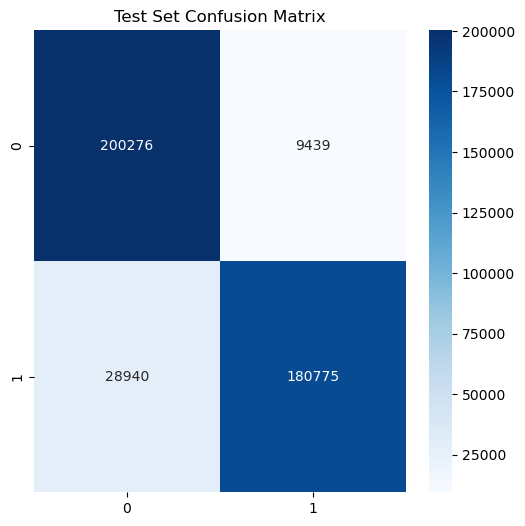

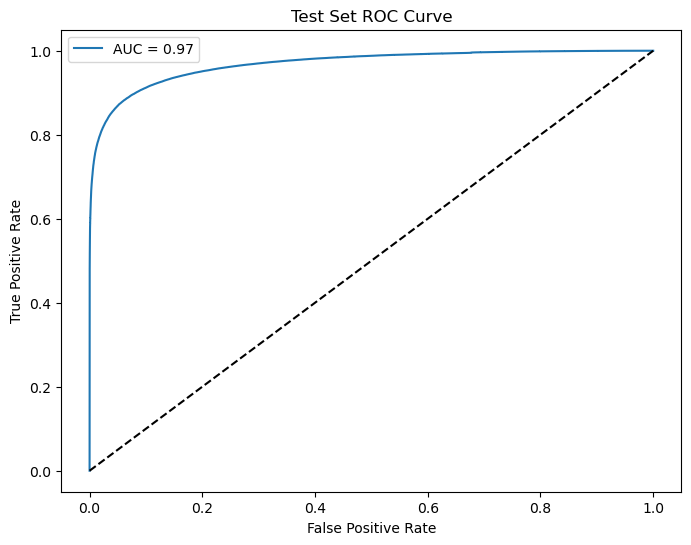

In [18]:
trainer.evaluate(test_loader)

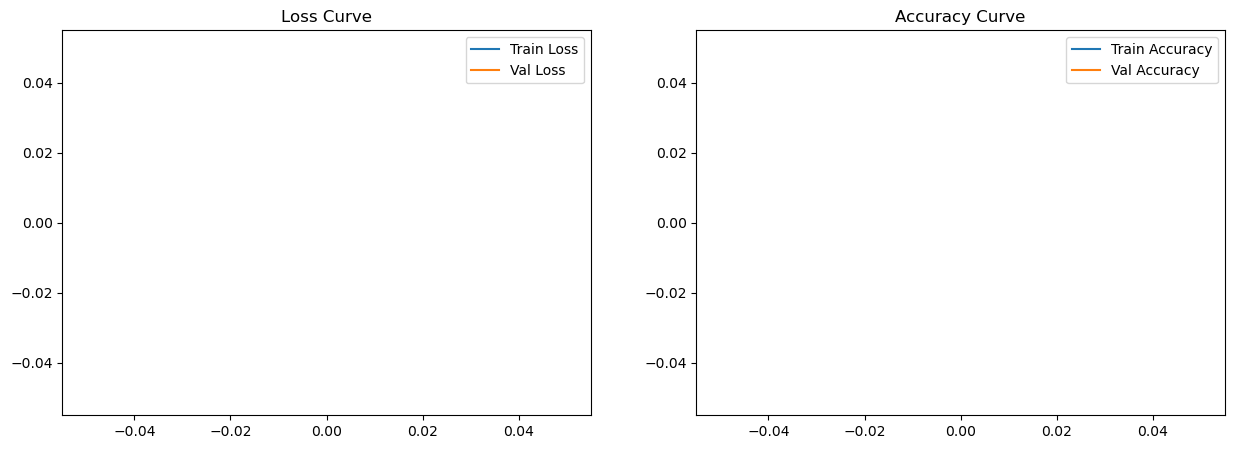

In [25]:
trainer.plot_metrics()